# BT4222 Assignment 3
By Teo Zhi Feng (A0203989N)

# 1 Setup

In [38]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv1D, Dense, Dropout, Embedding, Flatten, GlobalMaxPooling1D,  LSTM, MaxPooling1D, TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import string
import re

#### Import IMDB Dataset

In [39]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  29.6M      0  0:00:02  0:00:02 --:--:-- 29.6M


#### Inspect folder directory

In [40]:
!ls aclImdb
!ls aclImdb/test
!ls aclImdb/train

imdbEr.txt  imdb.vocab	README	test  train
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


In [41]:
!rm -r aclImdb/train/unsup

#### Import all datasets

In [42]:
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size
)

print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 625
Number of batches in raw_val_ds: 157
Number of batches in raw_test_ds: 782


#### Inspect dataset

In [43]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'I\'ve seen tons of science fiction from the 70s; some horrendously bad, and others thought provoking and truly frightening. Soylent Green fits into the latter category. Yes, at times it\'s a little campy, and yes, the furniture is good for a giggle or two, but some of the film seems awfully prescient. Here we have a film, 9 years before Blade Runner, that dares to imagine the future as somthing dark, scary, and nihilistic. Both Charlton Heston and Edward G. Robinson fare far better in this than The Ten Commandments, and Robinson\'s assisted-suicide scene is creepily prescient of Kevorkian and his ilk. Some of the attitudes are dated (can you imagine a filmmaker getting away with the "women as furniture" concept in our oh-so-politically-correct-90s?), but it\'s rare to find a film from the Me Decade that actually can make you think. This is one I\'d love to see on the big screen, because even in a widescreen presentation, I don\'t think the overall scope of this film would receive its

#### Define lsit to store model performance

In [44]:
results = {}

# 2 Data Pre-Processing

#### Standardise text

In [45]:
# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML). Because of this, we will need to
# create a custom standardization function.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )


# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Now that the vocab layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)

# Let's call `adapt`:
vectorize_layer.adapt(text_ds)

#### Vectorise text

In [46]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

#### Inspect vectorised dataset

In [47]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"This is yet another tell-it-as-it-is Madhur Bhandarkar film. I am not sure why he has this obsession to show Child moles***ion and g*y concepts to the Indian filmy audience, but I find some of those scenes really disgusting! What's new? It is a nice piece put together by Bhandarkar, where he shows the story of an entertainment reporter played by leading lady in the famous film, Mr & Mrs Iyer. What makes this movie different is, that it also covers the stories of people that this reporter interacts with or is friends with, such as her roomies, her colleagues, film stars, models, rich people and others featured in the Entertainment Page#3 in her newspaper.<br /><br />Noticeable: It is another good performance from Mrs Iyer. She is likely to be noticed for this role. She does selective roles but shines in them. She is noticeably de-glamorized and less beautiful in this film. But then, entertainment reporters are not supposed to outshine the people they cover, right? Ver

# 3 Convolutional Neural Network (CNN)

#### Model setup

In [83]:
epochs = 5
#batch_size = 256

#max_features = 5000 # max number of words in the corpus
embedding_dims = 50 # emddeding for each word
maxlen = 500 # max number of words in the review

filters = 50 
kernel_size = 3 # size of the 1D conv. layer
hidden_dims = 250 # number of dimensions

### Build model

In [84]:
model_cnn = Sequential()

# We start off with an efficient embedding layer which maps
# Our vocab indices into embedding_dims dimensions
model_cnn.add(Embedding(max_features,
                     embedding_dims,
                     input_length=maxlen))

# Convolution layer 1
model_cnn.add(Conv1D(filters,
                 kernel_size,
                 padding='same',
                 activation='relu',
                 strides=1))

# Max pooling
model_cnn.add(GlobalMaxPooling1D())
             
##### OTHER CONVOLUTION LAYERS #####
model_cnn.add(Dropout(0.5))

# Flatten before connecting back 
model_cnn.add(Flatten())

model_cnn.add(Dense(hidden_dims))
model_cnn.add(Dropout(0.5))
model_cnn.add(Activation('relu'))

# Project onto a single unit, dense output layer and apply sigmoid activation function
# to make 0 or 1 predictions for the two classes (positive or negative).
model_cnn.add(Dense(1))
model_cnn.add(Activation('sigmoid'))

In [85]:
# Use binary_crossentropy loss function as it is a binary classification problem 
model_cnn.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', "Precision", "Recall"])

#### Visualise model

In [86]:
model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 50)           1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 500, 50)           7550      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 50)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 250)               12750     
_________________________________________________________________
dropout_11 (Dropout)         (None, 250)              

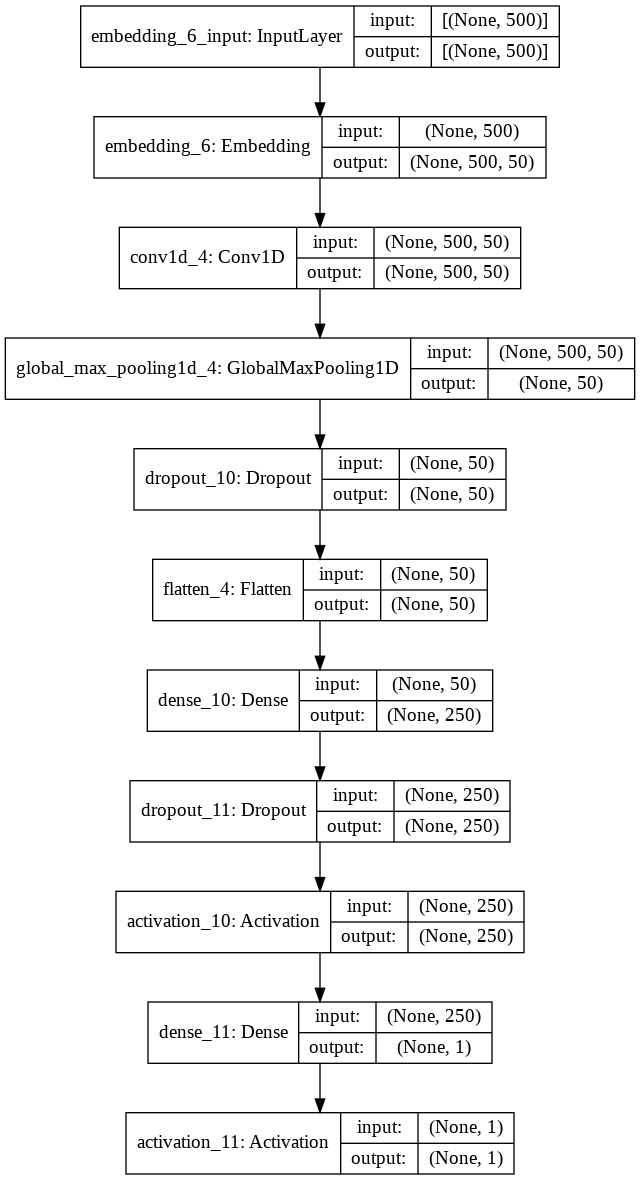

In [87]:
plot_model(model_cnn, "multi_input_and_output_model.png", show_shapes=True)

### Train model using train dataset

In [88]:
# Fit model using train dataset
history_cnn = model_cnn.fit(train_ds,
              epochs=epochs,
              verbose = 1,
              batch_size=batch_size,
              validation_data=val_ds,
              callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])

Epoch 1/20
625/625 [==============================] - 12s 12ms/step - loss: 0.5416 - accuracy: 0.7061 - precision: 0.6925 - recall: 0.7390 - val_loss: 0.4041 - val_accuracy: 0.8150 - val_precision: 0.7603 - val_recall: 0.9251
Epoch 2/20
625/625 [==============================] - 7s 11ms/step - loss: 0.3355 - accuracy: 0.8553 - precision: 0.8496 - recall: 0.8627 - val_loss: 0.3288 - val_accuracy: 0.8560 - val_precision: 0.8160 - val_recall: 0.9227
Epoch 3/20
625/625 [==============================] - 7s 11ms/step - loss: 0.2259 - accuracy: 0.9116 - precision: 0.9097 - recall: 0.9134 - val_loss: 0.3519 - val_accuracy: 0.8586 - val_precision: 0.8158 - val_recall: 0.9299
Epoch 4/20
625/625 [==============================] - 7s 12ms/step - loss: 0.1526 - accuracy: 0.9427 - precision: 0.9411 - recall: 0.9442 - val_loss: 0.3614 - val_accuracy: 0.8650 - val_precision: 0.8571 - val_recall: 0.8792
Epoch 5/20
625/625 [==============================] - 7s 11ms/step - loss: 0.1096 - accuracy: 0.960

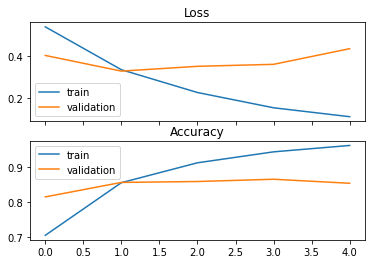

In [89]:
figure, axis = plt.subplots(2, sharex=True)

axis[0].plot(history_cnn.history['loss'], label='train')
axis[0].plot(history_cnn.history['val_loss'], label='validation')
axis[0].legend()
axis[0].set_title('Loss')

axis[1].plot(history_cnn.history['accuracy'], label='train')
axis[1].plot(history_cnn.history['val_accuracy'], label='validation')
axis[1].legend()
axis[1].set_title('Accuracy')

plt.show()

### Make predictions on test dataset

In [90]:
metrics_cnn = model_cnn.evaluate(test_ds,verbose=1)

782/782 [==============================] - 4s 5ms/step - loss: 0.4495 - accuracy: 0.8479 - precision: 0.8156 - recall: 0.8990


#### Evaluate model performance

In [91]:
loss_cnn = round(metrics_cnn[0], 3)
accuracy_cnn = round(metrics_cnn[1], 3)
precision_cnn = round(metrics_cnn[2], 3)
recall_cnn = round(metrics_cnn[3], 3)

print('Model performance on test set:\nLoss: {}\nAccuracy: {}\nPrecision: {}\nRecall: {}\n'.format(loss_cnn, accuracy_cnn, precision_cnn, recall_cnn))

Model performance on test set:
Loss: 0.45
Accuracy: 0.848
Precision: 0.816
Recall: 0.899



In [92]:
results['CNN'] = {
    'Loss': loss_cnn,
    'Accuracy': accuracy_cnn,
    'Precision': precision_cnn, 
    'Recall': recall_cnn,
    'F1-score': round( 2*((precision_cnn * recall_cnn) / (precision_cnn + recall_cnn)), 3 )
  }

# 4 Long Short-Term Memory (LSTM) 

### Build model

In [58]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_features,
                     embedding_dims,
                     input_length=maxlen))
model_lstm.add(LSTM(64))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.add(Activation('sigmoid'))

In [59]:
# Use binary_crossentropy loss function as it is a binary classification problem 
model_lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', "Precision", "Recall"])

#### Visualise model

In [60]:
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 10)           200000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                19200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 219,265
Trainable params: 219,265
Non-trainable params: 0
_________________________________________________________________


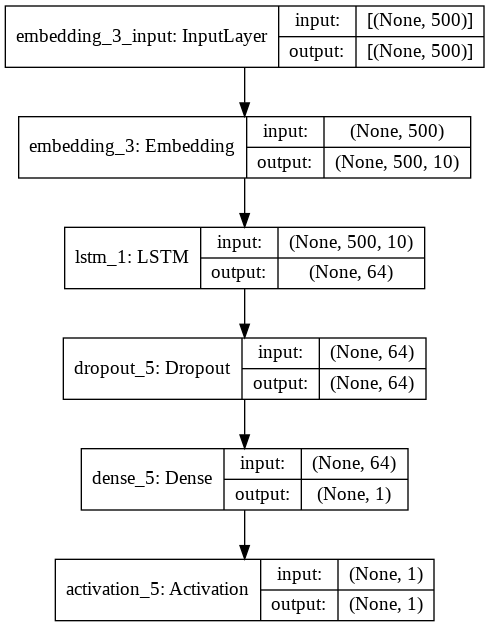

In [61]:
plot_model(model_lstm, "multi_input_and_output_model.png", show_shapes=True)

### Train model using train dataset

In [62]:
# Fit model using train dataset
history_lstm = model_lstm.fit(train_ds,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=val_ds,
              callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])

Epoch 1/5
558/625 [=========================>....] - ETA: 6s - loss: 0.6932 - accuracy: 0.5034 - precision: 0.5003 - recall: 0.4967

KeyboardInterrupt: ignored

In [ ]:
figure, axis = plt.subplots(2, sharex=True)

axis[0].plot(history_lstm.history['loss'], label='train')
axis[0].plot(history_lstm.history['val_loss'], label='validation')
axis[0].legend()
axis[0].set_title('Loss')

axis[1].plot(history_lstm.history['accuracy'], label='train')
axis[1].plot(history_lstm.history['val_accuracy'], label='validation')
axis[1].legend()
axis[1].set_title('Accuracy')

plt.show()

### Make predictions on test dataset

In [ ]:
metrics_lstm = model_lstm.evaluate(test_ds,verbose=1)

#### Evaluate model performance

In [ ]:
loss_lstm = round(metrics_lstm[0], 3)
accuracy_lstm = round(metrics_lstm[1], 3)
precision_lstm = round(metrics_lstm[2], 3)
recall_lstm = round(metrics_lstm[3], 3)

print('Model performance on test set:\nLoss: {}\nAccuracy: {}\nPrecision: {}\nRecall: {}\n'.format(loss_lstm, accuracy_lstm, precision_lstm, recall_lstm))

In [ ]:
results['LSTM'] = {
    'Loss': loss_lstm,
    'Accuracy': accuracy_lstm,
    'Precision': precision_lstm, 
    'Recall': recall_lstm,
    'F1-score': round( 2*((precision_lstm * recall_lstm) / (precision_lstm + recall_lstm)), 3 )
  }

# 5 Model Comparison
Metrics used = Precision, Recall and F1 Score

In [ ]:
results = pd.DataFrame(results)
results

From the results, we see that LSTM performed better in terms of precision, recall and F1 score because XXX.

# 6 Insights
The last 2 points will be given if you have provided any deeper insights. (For example but not limited to, provide empirical evidence for why one method is better than the other one; how the change of the network structure might influence the performance; how the data characteristics might influence the performance; any other aspects you want to highlight).

On their own, performance is comparable. However, performing sentiment analysis using CNN with LSTM can improve prediction performance.

https://medium.com/@mrunal68/text-sentiments-classification-with-cnn-and-lstm-f92652bc29fd

- CNN does not depend on the computations of the previous time steps and therefore allow parallelization over every element in a sequence.
- CNN obtains essential features of text through pooling but it is difficult to obtain contextual information.

- LSTM, and RNN in general, maintains a hidden state of the entire past that prevents parallel computation within a sequence.
- However, it can potentially lead to bias 

https://towardsdatascience.com/text-classification-rnns-or-cnn-s-98c86a0dd361

Improve:
- Problem of overfitting -> use dropout